In [1]:
%run 'datagetter.ipynb'
%run 'basic_functions.ipynb'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB


/var/folders/7f/pn2lysgd6cx02fkc066bbrp40000gn/T/ipykernel_45939/1263838836.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_oil_df['ds'] = pd.to_datetime(wti_oil_df['ds'])


In [ ]:
# sarima_model.py
"""
Utility to automate SARIMA modeling for a univariate time-series DataFrame.

Revision 1.3 (06 Jul 2025)
––––––––––––––––––––––––––
* **STL-driven seasonality discovery**: if you don’t provide ``seasonal_period``
  the routine now loops over a set of plausible periods (daily/weekly/annual
  relative to the sampling rate), decomposes each with STL, and chooses the
  one with the strongest seasonal variance.  Falls back to the old calendar
  rule or ACF-peak if STL finds nothing.

Usage
-----
>>> sarima_forecast(df)              # autodetect via STL → SARIMA/ARIMA
>>> sarima_forecast(df, 48)          # force daily seasonality for 30-min data
>>> sarima_forecast(df, 0)           # force non-seasonal ARIMA
"""

import itertools
import re
from sklearn.model_selection import train_test_split
import warnings
from typing import Tuple, Optional, Dict, Any, List
from pandas.tseries.frequencies import to_offset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

# -----------------------------------------------------------------------------
# Helper functions
# -----------------------------------------------------------------------------
def auto_detect_strongest_cycle(ts: pd.Series,
                                max_period: int = 1000
                               ) -> tuple[str, int, float]:
    """
    Infer sampling freq of `ts` (must have uniform DatetimeIndex),
    build candidate seasonal periods appropriate to that resolution
    (and ≤ max_period), then pick the one with highest autocorrelation.

    Returns
    -------
    best_name : str      e.g. "daily", "quarterly", "annual"
    best_period : int    number of samples in one cycle
    best_corr : float    autocorrelation at that lag
    """
    if not isinstance(ts.index, pd.DatetimeIndex):
        raise ValueError("`ts` must have a DatetimeIndex")
    ts = ts.sort_index().dropna()

    # 1) infer frequency
    freq = pd.infer_freq(ts.index)
    if freq is None:
        raise ValueError("Could not infer frequency. Is your index equally spaced?")
    off = to_offset(freq)
    # check if time-based or month/year-based
    has_seconds = hasattr(off, 'delta')
    candidates = {}

    if has_seconds and off.delta.total_seconds() < 86400:
        # sub-daily (e.g. 30T, H, etc.)
        sec = off.delta.total_seconds()
        per_day = int(86400 // sec)
        candidates = {
            "daily":   per_day,
            "weekly":  per_day * 7,
            "monthly": per_day * 30,
            "yearly":  per_day * 365,
        }
    else:
        # day or coarser
        s = off.freqstr.upper()
        if s in ("D","B"):
            candidates = {
                "weekly": 7,
                "monthly": 30,
                "annual": 365,
            }
        elif s in ("M", "MS", "BM"):
            candidates = {
                "quarterly": 3,
                "semiannual": 6,
                "annual": 12,
            }
        elif s in ("Q","BQ"):
            candidates = {
                "semiannual": 2,
                "annual": 4,
            }
        elif s in ("A","Y","BA"):
            candidates = {
                "annual": 1,
            }
        else:
            # fallback: no good candidates
            raise ValueError(f"Unrecognized frequency '{freq}' for auto-detection.")

    # 2) filter by max_period
    candidates = {n: p for n, p in candidates.items() if p <= max_period}
    if not candidates:
        raise ValueError(f"No candidate periods ≤ {max_period}. Increase `max_period`.")

    # 3) compute autocorrelations
    corrs = {}
    for name, lag in candidates.items():
        # pandas autocorr uses `lag` in number of samples
        corrs[name] = ts.autocorr(lag=lag) or 0.0

    # 4) pick strongest (abs value)
    best_name, best_corr = max(corrs.items(), key=lambda kv: abs(kv[1]))
    best_period = candidates[best_name]

    return best_name, best_period, best_corr


def _adf_test(series: pd.Series, alpha: float = 0.05) -> Tuple[bool, float]:
    series = series.dropna()
    pval = adfuller(series)[1]
    return pval < alpha, pval


def difference_until_stationary(
    series: pd.Series,
    show_plots: bool = True,
    max_d: int = 2,
    alpha: float = 0.05,
    nlags: int = 40,
) -> Tuple[pd.Series, int, int]:
    """
    Differences a time series until it becomes stationary, plots ACF/PACF before and after,
    and returns the stationary series with differencing orders.

    Args:
        series: Original time series (pd.Series).
        seasonal_lag: Seasonal lag for seasonal differencing (e.g., 12 for monthly data).
        max_d: Maximum number of non-seasonal differences.
        alpha: Significance level for ADF test.
        nlags: Number of lags to compute for ACF/PACF.

    Returns:
        s: Differenced (stationary) series.
        d: Number of non-seasonal differences applied.
        D: Number of seasonal differences applied.
    """
    # Compute ACF/PACF before differencing
    series_clean = series.dropna()

    # Test and difference
    s = series.copy()
    d = D = 0
    stationary, _ = _adf_test(s.dropna(), alpha)
    while not stationary and d < max_d:
        d += 1
        s = s.diff().dropna()
        stationary, _ = _adf_test(s, alpha)


    if show_plots:
        # Plotting before and after differencing
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        axes = axes.flatten()

        # ACF before
        plot_acf(series_clean, lags=nlags, ax=axes[0])
        axes[0].set_title('ACF Before Differencing')

        # PACF before
        plot_pacf(series_clean, lags=nlags, ax=axes[1])
        axes[1].set_title('PACF Before Differencing')

        # ACF after
        plot_acf(s, lags=nlags, ax=axes[2])
        axes[2].set_title('ACF After Differencing')

        # PACF after
        plot_pacf(s, lags=nlags, ax=axes[3])
        axes[3].set_title('PACF After Differencing')

        plt.tight_layout()
        plt.show()

    return s, d, D




def _find_season_via_stl(y: pd.Series, candidates: List[int], robust: bool = True) -> int:
    """Return period that yields strongest seasonal variance in STL, else 0."""
    best_m, best_strength = 0, 0.0
    for m in candidates:
        try:
            res = STL(y, period=m, robust=robust).fit()
            strength = res.seasonal.var() / y.var()
            if strength > best_strength:
                best_strength, best_m = strength, m
        except ValueError:
            # STL may fail if period > len(y)//2 etc.
            continue
    return best_m if best_strength > 0.05 else 0  # 5-% heuristic

# -----------------------------------------------------------------------------
# Main routine
# -----------------------------------------------------------------------------

def sarima_forecast(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    seasonal_period: Optional[int] = None,
    order_grid: Tuple[range, range] = (range(3), range(3)),
    seasonal_order_grid: Tuple[range, range] = (range(2), range(2)),
    alpha: float = 0.05,
    ljungbox_lags = np.arange(1, 11, 1),
    show_plots: bool = True,
    figsize: Tuple[int, int] = (14, 6),
    **sarimax_kwargs: Dict[str, Any],
):
    """Fit SARIMA/ARIMA with automatic season detection via STL.

    Parameters
    ----------
    train_df : DataFrame with ``ds`` & ``y``.
    seasonal_period : int or None
        * None  → attempt automatic detection (calendar → STL → ACF → 0).
        * 0     → force non-seasonal ARIMA.
        * >0    → use that value as *m*.
    stl_candidates : list[int], optional
        Overrides the default list of candidate periods passed into STL.
    """

    # -- Prepare data ---------------------------------------------------
    data = train_df.copy()
    data["ds"] = pd.to_datetime(data["ds"])
    data = data.set_index("ds").sort_index()
    forecast_steps = len(test_df)

    try:
        data = data.asfreq(pd.infer_freq(data.index))
    except (ValueError, TypeError):
        pass

    y = data["y"].astype(float)

    # -- Determine seasonal period m -----------------------------------
    if seasonal_period is None:
        best_name, best_period, best_corr = auto_detect_strongest_cycle(y)
        seasonal_period = best_period



    no_seasonality = seasonal_period == 0

    # -- STL plot (optional) -------------------------------------------
    if show_plots and not no_seasonality:
        STL(y, period=seasonal_period, robust=True).fit().plot()
        plt.suptitle(f"STL decomposition (m={seasonal_period})", y=1.02)
        plt.show()

    # -- Differencing ---------------------------------------------------
    _, d, D = difference_until_stationary(y, show_plots=show_plots)
    if no_seasonality:
        D = 0
        seasonal_order_grid = (range(1), range(1))

    # -- Grid-search ----------------------------------------------------
    best_aic = np.inf
    best_model = None
    p_range, q_range = order_grid
    P_range, Q_range = seasonal_order_grid
    
    # Store all model results
    model_results = []
    
    print("\nEvaluating SARIMA models:")
    print("-" * 60)
    print(f"{'Model':40} {'AIC':>10} {'Status':>8}")
    print("-" * 60)
    
    for p, q, P, Q in itertools.product(p_range, q_range, P_range, Q_range):
        order = (p, d, q)
        seasonal_order = (0, 0, 0, 0) if no_seasonality else (P, D, Q, seasonal_period)
        model_name = f"SARIMA{order}x{seasonal_order}"
        
        try:
            model = SARIMAX(
                y, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False,
                **sarimax_kwargs
            ).fit(disp=False)
            
            current_aic = model.aic
            model_results.append((model_name, current_aic, model))
            status = "✓"
            
            if current_aic < best_aic:
                best_aic = current_aic
                best_model = model
                best_order = order
                best_seasonal = seasonal_order
                
            print(f"{model_name:40} {current_aic:10.2f} {status:>8}")
            
        except Exception as e:
            print(f"{model_name:40} {'N/A':>10} {'✗':>8}")
            continue

    if best_model is None:
        raise RuntimeError("No SARIMA candidate converged – inspect data or widen grid.")

    # Sort and display top 5 models
    model_results.sort(key=lambda x: x[1])
    print("\nTop 5 Models:")
    print("-" * 60)
    print(f"{'Model':40} {'AIC':>10} {'Rank':>8}")
    print("-" * 60)
    for i, (model_name, aic, _) in enumerate(model_results[:5], 1):
        print(f"{model_name:40} {aic:10.2f} {i:>8}")
    print("-" * 60)
    
    print(f"\nBest model: SARIMA{best_order}x{best_seasonal} – AIC={best_aic:.2f}\n")

    # -- Residual diagnostics -----------------------------------------
    resid = best_model.resid.dropna()
    if show_plots:
        fig, ax = plt.subplots(2, 2, figsize=figsize)
        sns.histplot(resid, kde=True, ax=ax[0, 0]); ax[0, 0].set_title("Residual distribution")
        qqplot(resid, line="s", ax=ax[0, 1]); ax[0, 1].set_title("Q-Q plot")
        plot_acf(resid, lags=40, ax=ax[1, 0]); ax[1, 0].set_title("Residual ACF")
        plot_pacf(resid, lags=40, ax=ax[1, 1]); ax[1, 1].set_title("Residual PACF")
        plt.tight_layout(); plt.show()
        lb = acorr_ljungbox(resid, ljungbox_lags, return_df=True)
        plt.figure(figsize=(6, 3))
        sns.lineplot(data=lb, x=lb.index, y="lb_pvalue")
        plt.axhline(alpha, ls="--", label=f"p = {alpha}")
        plt.ylim(0, 1)
        plt.xlabel("Lag")
        plt.title("Ljung-Box p-values vs lags")
        plt.legend()
        plt.show()

    # -- Forecast -------------------------------------------------------
    step = y.index[-1] - y.index[-2] if len(y) > 1 else pd.Timedelta("1D")
    f_idx = pd.date_range(start=y.index[-1] + step, periods=forecast_steps, freq=y.index.freq or step)
    pred_res = best_model.get_forecast(steps=forecast_steps, alpha=alpha)
    ci = pred_res.conf_int(alpha=alpha)
    forecasts = pd.DataFrame({
        "y_pred": pred_res.predicted_mean,
        "y_lower": ci.iloc[:, 0],
        "y_upper": ci.iloc[:, 1]
    }, index=f_idx)

    if show_plots:
        plt.figure(figsize=figsize)
        plt.plot(y, label="Observed")
        plt.plot(forecasts.index, forecasts["y_pred"], label="Forecast")
        plt.plot(test_df['ds'], test_df["y"], label="Test")
        plt.fill_between(forecasts.index, forecasts["y_lower"], forecasts["y_upper"], alpha=0.2,
                         label=f"{int((1-alpha)*100)}% CI")
        title = "ARIMA fit & forecast" if no_seasonality else f"SARIMA (m={seasonal_period}) fit & forecast"
        plt.legend(); plt.title(title); plt.show()

    return best_model, forecasts






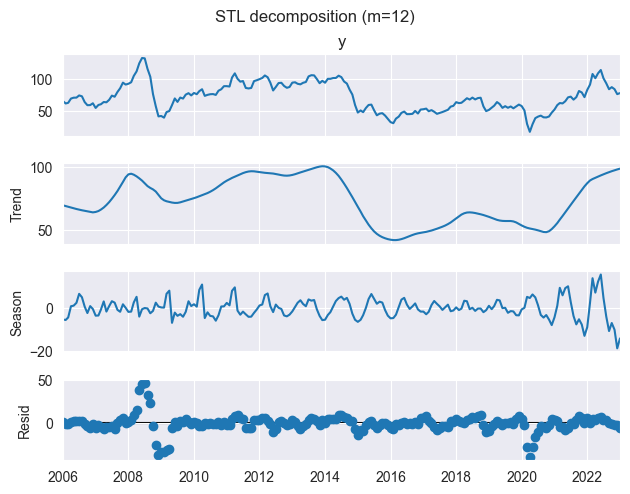

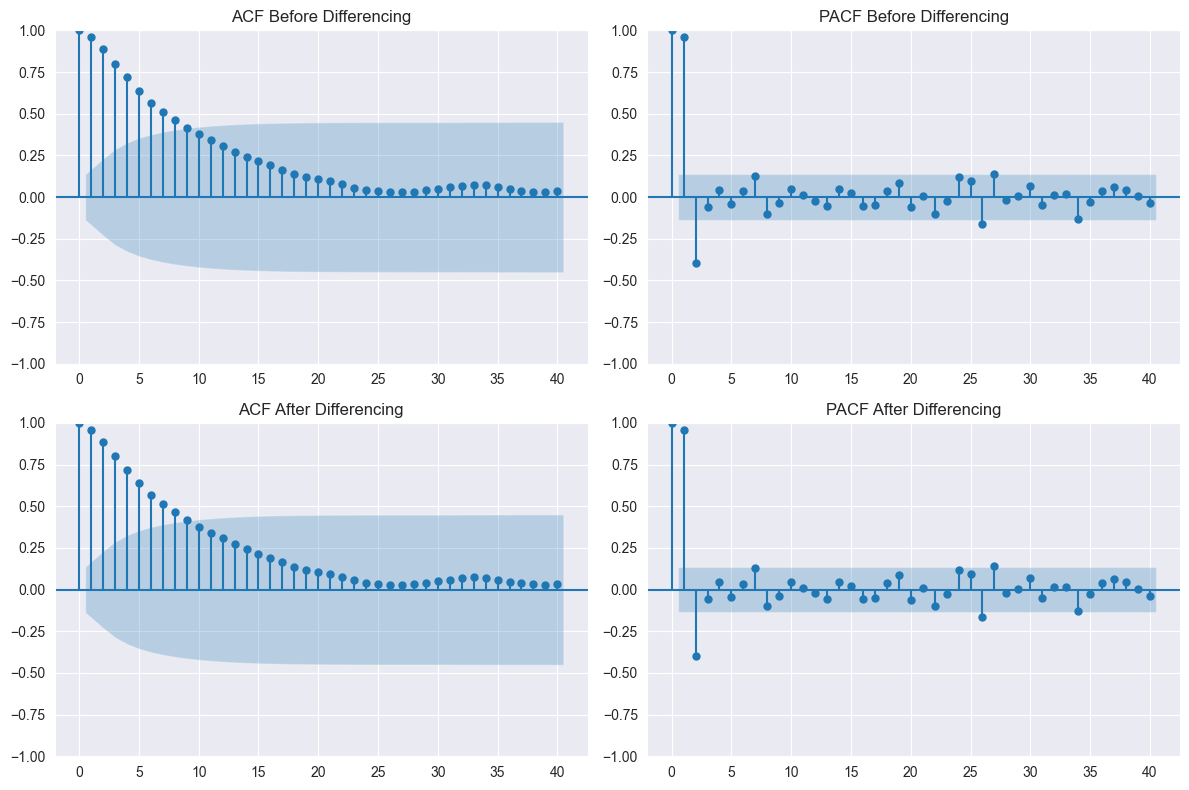


Evaluating SARIMA models:
------------------------------------------------------------
Model                                           AIC   Status
------------------------------------------------------------
SARIMA(0, 0, 0)x(0, 0, 0, 12)               2345.88        ✓
SARIMA(0, 0, 0)x(0, 0, 1, 12)               2043.47        ✓
SARIMA(0, 0, 0)x(1, 0, 0, 12)               1815.86        ✓
SARIMA(0, 0, 0)x(1, 0, 1, 12)               1772.32        ✓
SARIMA(0, 0, 1)x(0, 0, 0, 12)               2072.98        ✓
SARIMA(0, 0, 1)x(0, 0, 1, 12)               1795.40        ✓
SARIMA(0, 0, 1)x(1, 0, 0, 12)               1612.24        ✓
SARIMA(0, 0, 1)x(1, 0, 1, 12)               1556.61        ✓
SARIMA(0, 0, 2)x(0, 0, 0, 12)               1863.71        ✓
SARIMA(0, 0, 2)x(0, 0, 1, 12)               1627.83        ✓
SARIMA(0, 0, 2)x(1, 0, 0, 12)               1490.98        ✓
SARIMA(0, 0, 2)x(1, 0, 1, 12)               1426.64        ✓
SARIMA(1, 0, 0)x(0, 0, 0, 12)               1348.58       

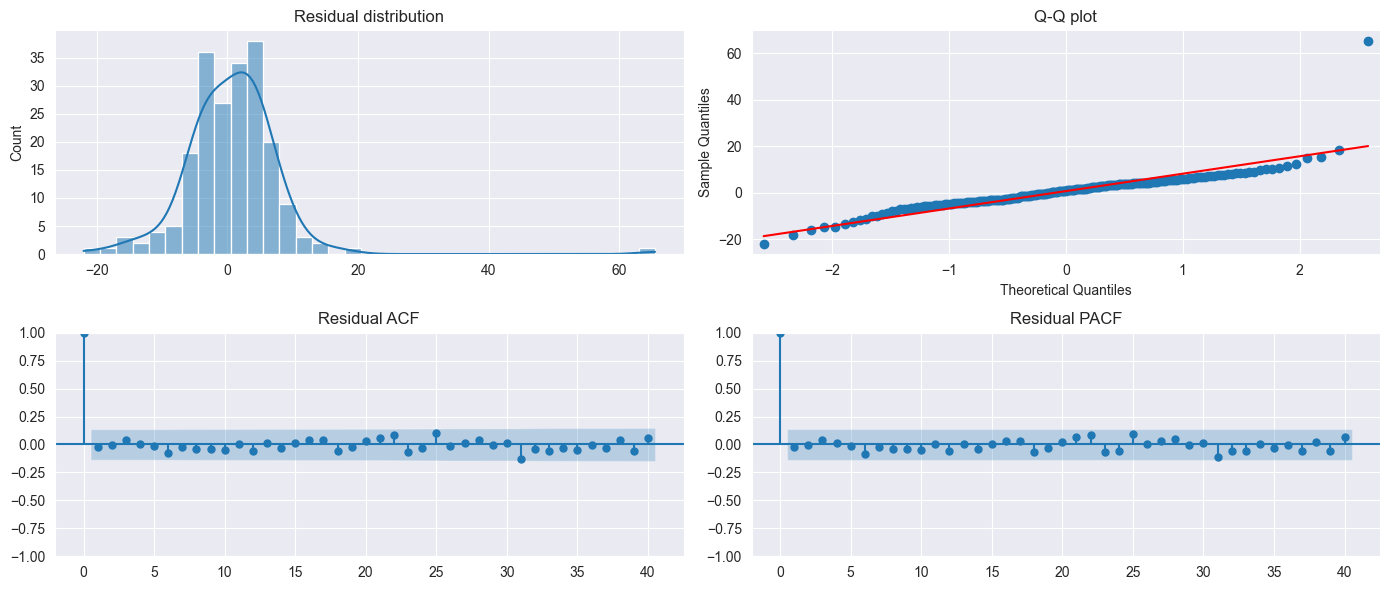

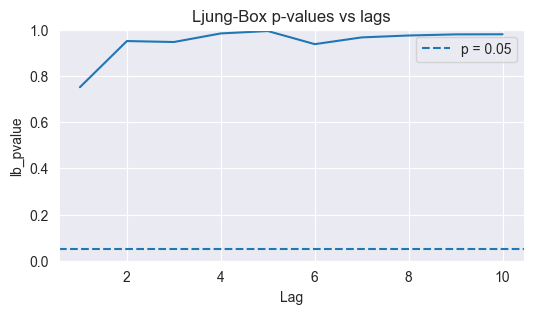

/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


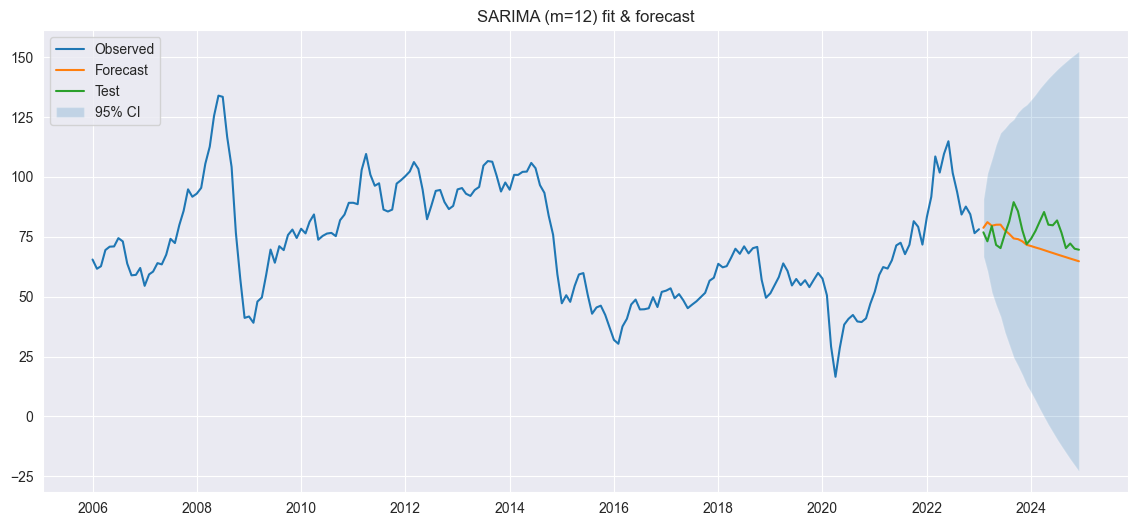

In [23]:
train_df, test_df = split_train_test(wti_oil_df, test_size=0.1)
sarima_model, sarima_forecast_df = sarima_forecast(
    train_df=train_df,
    test_df=test_df,
)

In [27]:
train_df, test_df = split_train_test(saugeen_river_df, test_size=0.1)
sarima_model, sarima_forecast_df = sarima_forecast(
    train_df=train_df,
    test_df=test_df,
    order_grid=(range(4), range(4)),
    seasonal_order_grid = (range(4), range(4))
)

SyntaxError: incomplete input (1844401181.py, line 7)

/var/folders/7f/pn2lysgd6cx02fkc066bbrp40000gn/T/ipykernel_24054/4049316307.py:66: FutureWarning: Day.delta is deprecated and will be removed in a future version. Use pd.Timedelta(obj) instead
  has_seconds = hasattr(off, 'delta')
/var/folders/7f/pn2lysgd6cx02fkc066bbrp40000gn/T/ipykernel_24054/4049316307.py:69: FutureWarning: Day.delta is deprecated and will be removed in a future version. Use pd.Timedelta(obj) instead
  if has_seconds and off.delta.total_seconds() < 86400:


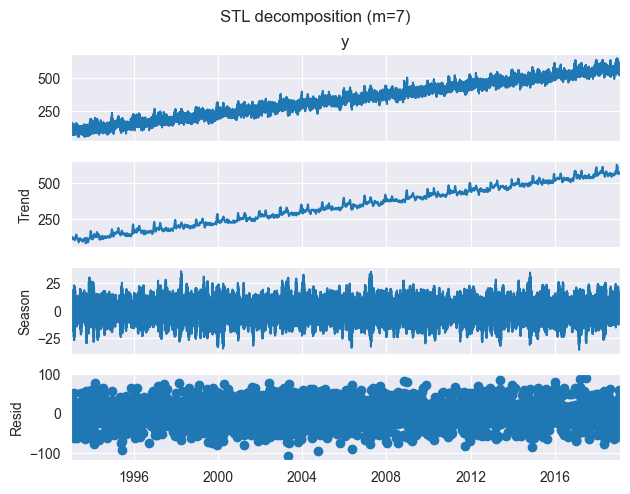

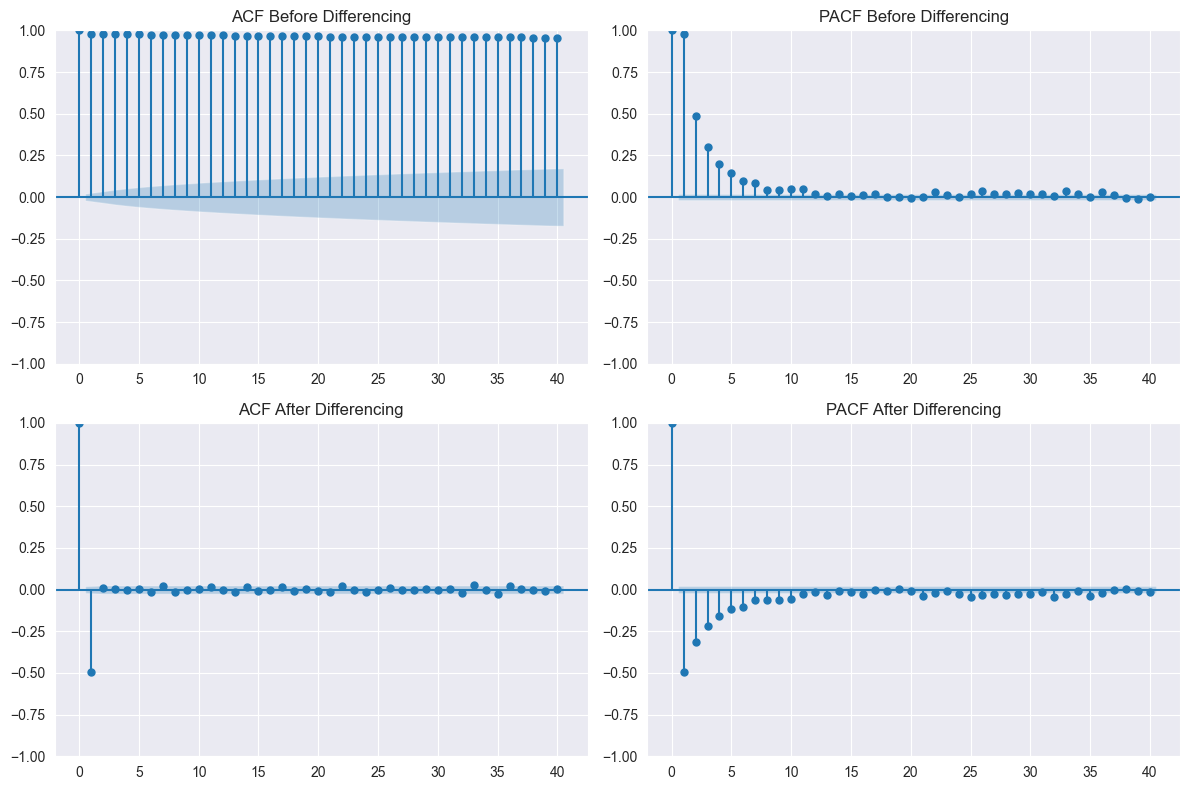


Evaluating SARIMA models:
------------------------------------------------------------
Model                                           AIC   Status
------------------------------------------------------------
SARIMA(0, 1, 0)x(0, 0, 0, 7)               91095.95        ✓
SARIMA(0, 1, 0)x(0, 0, 1, 7)               91033.61        ✓
SARIMA(0, 1, 0)x(1, 0, 0, 7)               91042.58        ✓
SARIMA(0, 1, 0)x(1, 0, 1, 7)               91032.14        ✓
SARIMA(0, 1, 1)x(0, 0, 0, 7)               86294.39        ✓
SARIMA(0, 1, 1)x(0, 0, 1, 7)               86239.00        ✓
SARIMA(0, 1, 1)x(1, 0, 0, 7)               86255.21        ✓
SARIMA(0, 1, 1)x(1, 0, 1, 7)               86240.96        ✓
SARIMA(0, 1, 2)x(0, 0, 0, 7)               86287.90        ✓
SARIMA(0, 1, 2)x(0, 0, 1, 7)               86227.40        ✓
SARIMA(0, 1, 2)x(1, 0, 0, 7)               86257.14        ✓
SARIMA(0, 1, 2)x(1, 0, 1, 7)               86228.02        ✓
SARIMA(1, 1, 0)x(0, 0, 0, 7)               88393.26       

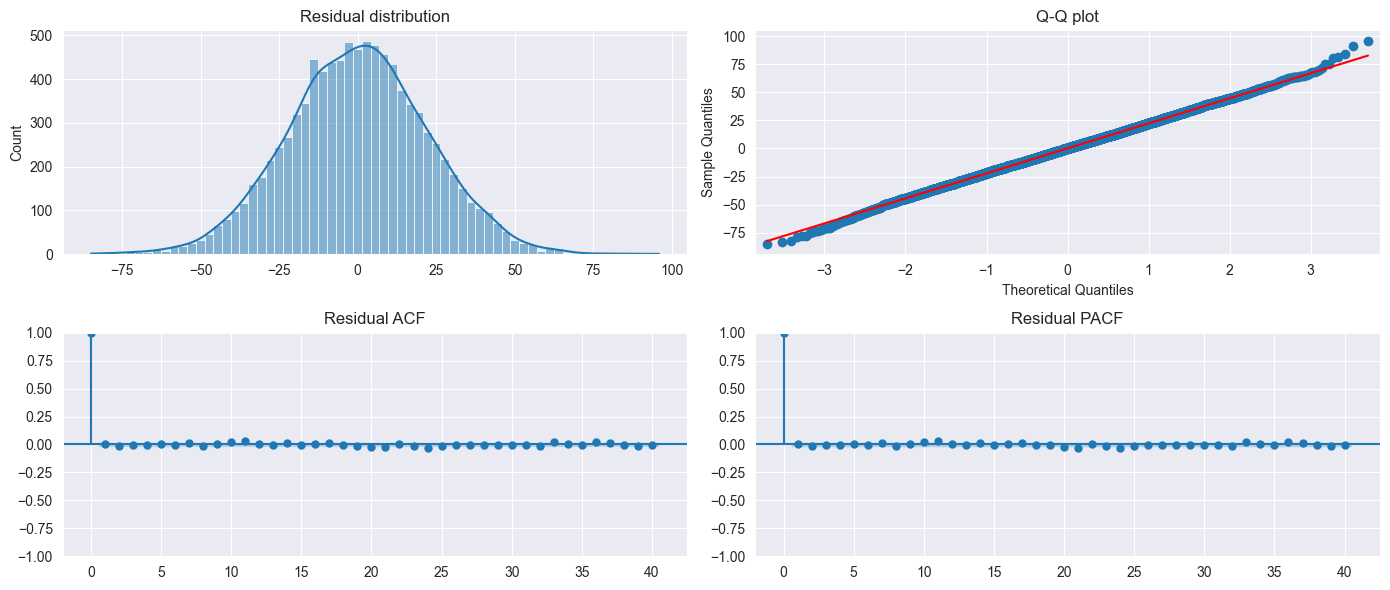

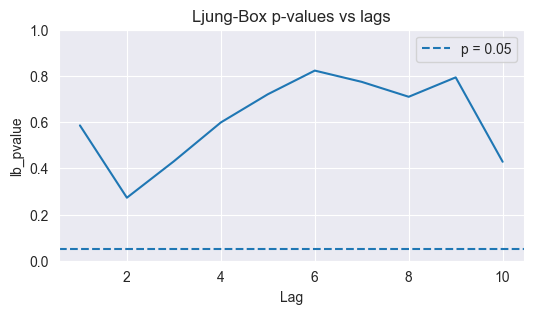

/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


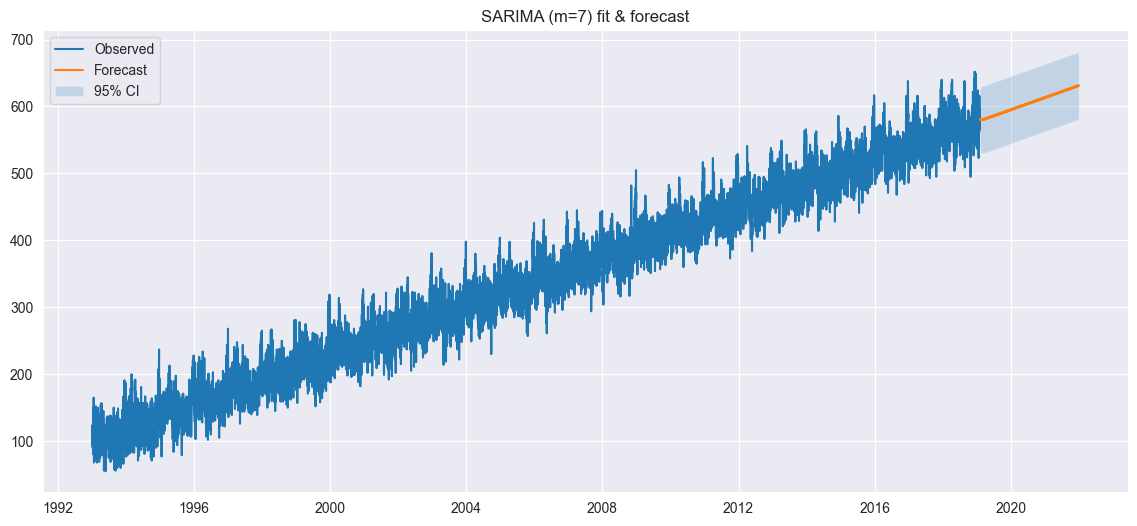

In [29]:
train_df, test_df = split_train_test(egg_sales_df, test_size=0.1)
sarima_model, sarima_forecast_df = sarima_forecast(
    train_df=train_df,
    test_df=test_df,
)

/var/folders/7f/pn2lysgd6cx02fkc066bbrp40000gn/T/ipykernel_45939/275087993.py:66: FutureWarning: Day.delta is deprecated and will be removed in a future version. Use pd.Timedelta(obj) instead
  has_seconds = hasattr(off, 'delta')
/var/folders/7f/pn2lysgd6cx02fkc066bbrp40000gn/T/ipykernel_45939/275087993.py:69: FutureWarning: Day.delta is deprecated and will be removed in a future version. Use pd.Timedelta(obj) instead
  if has_seconds and off.delta.total_seconds() < 86400:


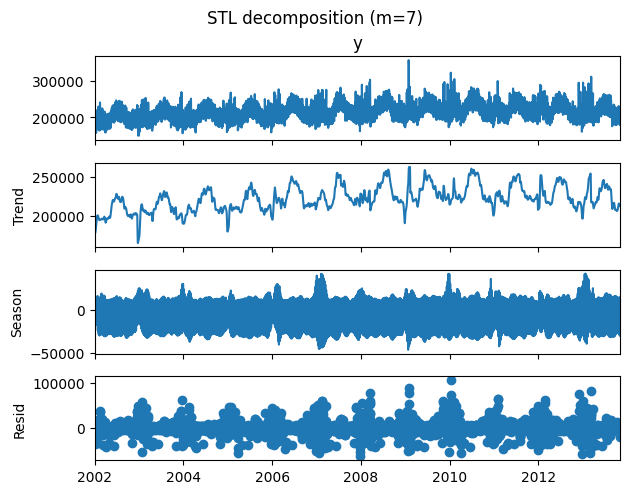

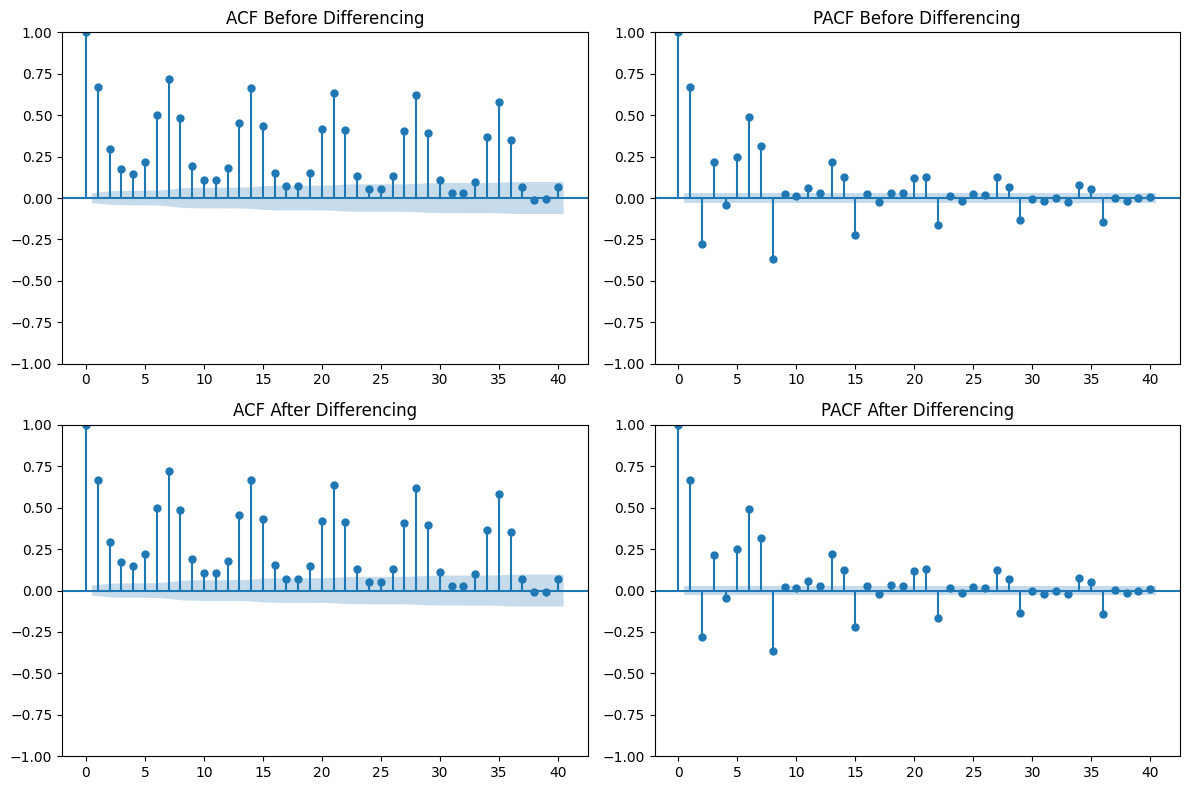


Evaluating SARIMA models:
------------------------------------------------------------
Model                                           AIC   Status
------------------------------------------------------------
SARIMA(0, 0, 0)x(0, 0, 0, 7)              118854.93        ✓
SARIMA(0, 0, 0)x(0, 0, 1, 7)              115603.92        ✓
SARIMA(0, 0, 0)x(1, 0, 0, 7)               97364.18        ✓
SARIMA(0, 0, 0)x(1, 0, 1, 7)               96450.38        ✓
SARIMA(0, 0, 1)x(0, 0, 0, 7)              115623.37        ✓
SARIMA(0, 0, 1)x(0, 0, 1, 7)              114707.61        ✓
SARIMA(0, 0, 1)x(1, 0, 0, 7)              114352.46        ✓
SARIMA(0, 0, 1)x(1, 0, 1, 7)              114296.54        ✓
SARIMA(0, 0, 2)x(0, 0, 0, 7)              114881.86        ✓
SARIMA(0, 0, 2)x(0, 0, 1, 7)              114430.95        ✓
SARIMA(0, 0, 2)x(1, 0, 0, 7)              114358.58        ✓
SARIMA(0, 0, 2)x(1, 0, 1, 7)              114275.89        ✓
SARIMA(1, 0, 0)x(0, 0, 0, 7)               98245.00       

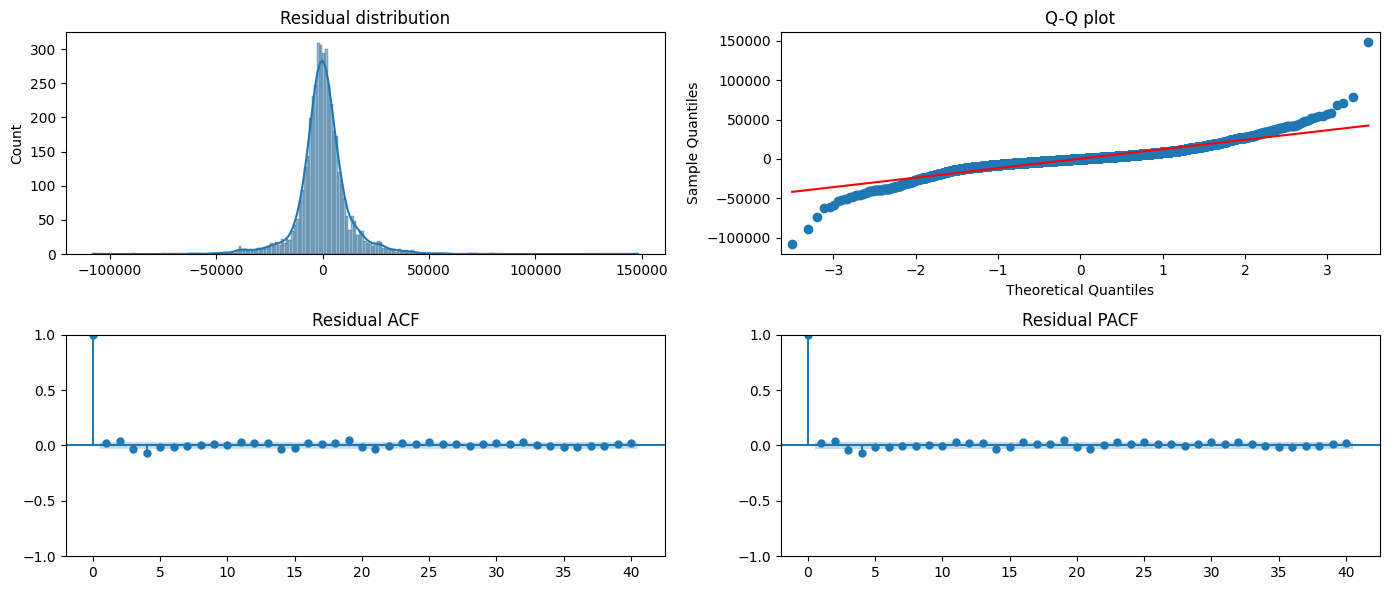

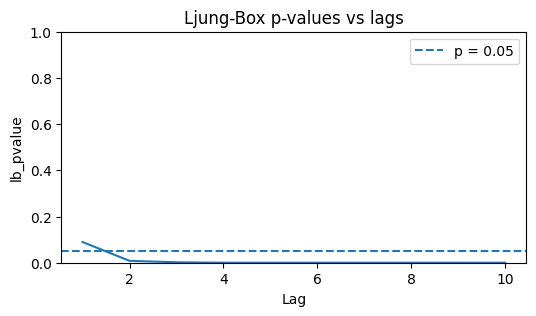

/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


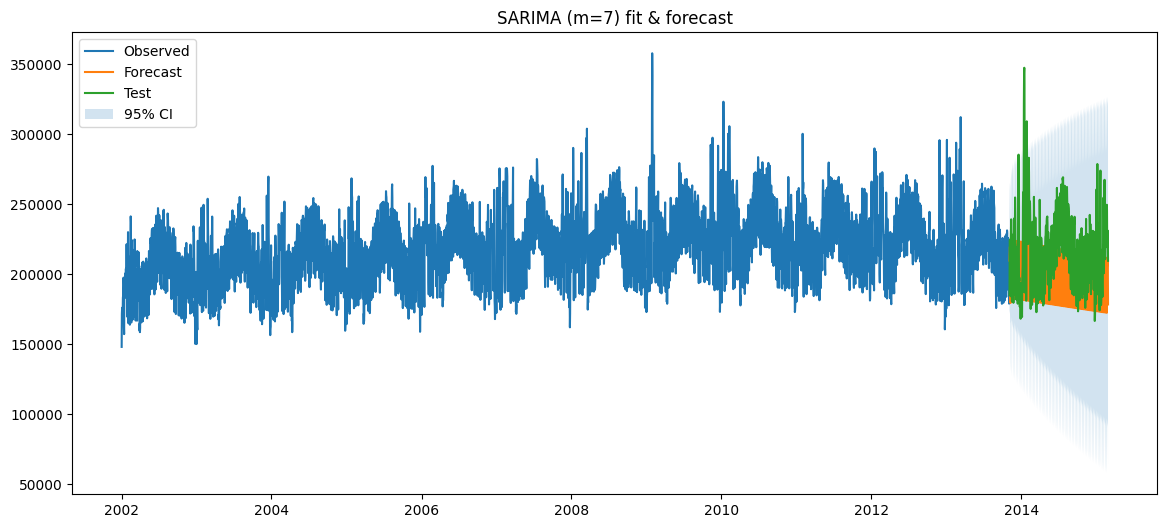

In [3]:
train_df, test_df = split_train_test(australian_electricity_demand_df, test_size=0.1)
sarima_model, sarima_forecast_df = sarima_forecast(
    train_df=train_df,
    test_df=test_df,
)